# Part 2: Fan Base Prediction

## Load dataset

In [1]:
import json

file_name = 'tweets_#superbowl.txt'


locations_MA = ['MA', ' MA', 'Massachusetts', 'Boston', 'Cambridge', 'Worcester', 'Marlborough',
               'Salem', 'Beverly', 'Yarmouth', 'Watertown', 'New Bedford', 'Waltham', 'Natick',
               'Cape Cod', 'Lowell', 'Quincy', 'Brookline', 'Somerville','Springfield', 'amherst',
               'framingham']
locations_WA = ['WA', ' WA', 'Seattle', 'Washington', 'Kirkland', 'Perth', 'Woodinville', 'Spokane', 'Pullman',
               'Renton', 'Everett','Puyallup', 'Olympia', 'Redmond', 'Bellevue', 'Bellingham',
               'Vancouver', 'Tacoma', 'Spokane', 'auburn', 'kennewick', 'kent', 'yakima']



In [2]:
texts = []
locations = []        #0 for MA and 1 for WA

def from_MA(loc):
    for x in locations_MA:
        if(x in loc):
            return True
    return False

def from_WA(loc):
    for x in locations_WA:
        if(x in loc):
            return True
    return False

locs_MA = []
locs_WA = []

filestream = open(file_name, 'r', encoding = 'utf-8')
for line in filestream:
    tweet = json.loads(line)
    text = tweet['tweet']['text']

    loc = tweet['tweet']['user']['location']
    
    if from_MA(loc):
        texts.append(text)
        locations.append(0)
        locs_MA.append(0)
        
    elif from_WA(loc):
        texts.append(text)
        locations.append(1)
        locs_WA.append(0)
        
filestream.close()

In [3]:
print(len(texts))
#print(len(locs_MA))
#print(len(locs_WA))

55355


## Process Data

In [18]:
import nltk
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import string
from string import punctuation
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import auc, confusion_matrix, recall_score, roc_curve, precision_score, accuracy_score
from sklearn.preprocessing import normalize, Normalizer
import itertools
import numpy as np
import re
from matplotlib import pyplot as plt


In [5]:
stop_words = text.ENGLISH_STOP_WORDS
#stop_words_skt = text.ENGLISH_STOP_WORDS
#stop_words_en = stopwords.words('english')
#stop_words = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

def stem_tokenizer(text):
    stemmer = SnowballStemmer("english")
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    words = text.split()
    stemmed = [stemmer.stem(item) for item in words]
    words_new = []
    for word in stemmed:
        if re.search('[a-z]{2,}',word):
            words_new.append(word)
    return words_new

def produce_pipeline(MIN_DF, CLF):
    pipe = Pipeline([('vect', CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = MIN_DF)),
                     ('tfidf', TfidfTransformer()),
                     ('reduce_dim', NMF(n_components = 50, init = 'random', random_state = 0)),
                     ('clf', CLF)])
    return pipe


def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)
    
    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.6', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title('ROC Curve')

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

    plt.show()

    
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix without Normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f' % cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j]>thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def compute_and_plot_confusion_matrix(test_label, test_predicted):
    cnf_matrix = confusion_matrix(test_label, test_predicted)
    np.set_printoptions(precision = 2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = bclasses, title = 'Confusion Matrix without Normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = bclasses, normalize = True, title = 'Normalized Confusion Matrix')
    plt.show()

In [13]:
vectorizer = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

svd = TruncatedSVD(n_components=50, algorithm='arpack')
nmf = NMF(n_components=50, init='random', random_state=0)
normalizer = Normalizer(norm = 'l2', copy=False)

bclasses = ['Massachusetts','Washington']

X_train, X_test, y_train, y_test = train_test_split(texts, locations, train_size=0.9, random_state=42)
pipe = Pipeline([('vect', vectorizer),
                 ('tfidf', tfidf_transformer),
                 ('svd', svd),
                 ('norm', normalizer)])

train_svd_data = pipe.fit_transform(X_train)
test_svd_data = pipe.fit_transform(X_test)

C:\Users\nobod\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Linear SVM Classifier

In [ ]:
svm = SVC(kernel='linear', probability=True, C=1000)
svm.fit(train_svd_data, y_train)

test_score = svm.predict_proba(test_svd_data)
test_predict = svm.predict(test_svd_data)

fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])

plot_roc(fpr, tpr)
compute_and_plot_confusion_matrix(y_test, test_predict)

accuracy = accuracy_score(y_test, test_predict)
print('Accuracy:',accuracy)

recall = recall_score(y_test, test_predict)
print('Recall:',recall)

precision = precision_score(y_test, test_predict)
print('Precision:',precision)


## Help function: Calculate model and plots

In [45]:
def report_model(pipe):
    X = np.array(texts)
    y = np.array(locations)

    vect_2 = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
    tfidf_transformer = TfidfTransformer()

    bclasses = ['Massachusetts','Washington']

    accuracies = list()
    recalls = list()
    precisions = list()

    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(texts):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = list(X_train)
        y_train = list(y_train)
        X_test = list(X_test)
        y_test = list(y_test)

        pipe.fit(X_train, y_train)

        test_score = pipe.predict_proba(X_test)

        test_predict = pipe.predict(X_test)

        fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])

        plot_roc(fpr, tpr)
        compute_and_plot_confusion_matrix(y_test, test_predict)

        accuracy = accuracy_score(y_test, test_predict)
        accuracies.append(accuracy)
        print('Accuracy:',accuracy)

        recall = recall_score(y_test, test_predict)
        recalls.append(recall)
        print('Recall:',recall)

        precision = precision_score(y_test, test_predict)
        precisions.append(precision)
        print('Precision:',precision)

        print('-'*40)

    print('The average accuracy is %.4f'%(sum(accuracies)/len(accuracies)))
    print('The average recall is %.4f'%(sum(recalls)/len(recalls)))
    print('The average precision is %.4f'%(sum(precisions)/len(precisions)))

## MultinomialNB

C:\Users\nobod\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


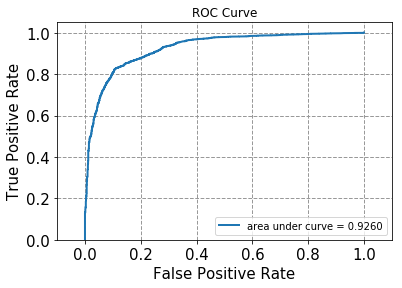

Confusion Matrix without Normalization
[[ 191 1433]
 [  12 3900]]
Normalized Confusion Matrix
[[0.12 0.88]
 [0.   1.  ]]


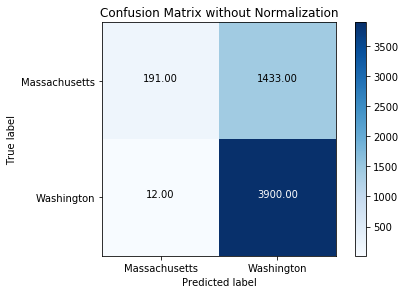

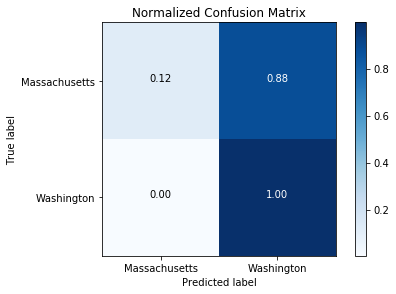

Accuracy: 0.7389812138728323
Recall: 0.9969325153374233
Precision: 0.7312957059816239
------------------------------


In [ ]:
pipe = produce_pipeline(2, MultinomialNB())
report_model(pipe)

## GaussianNB

In [ ]:
X = np.array(texts)
y = np.array(locations)

vect_2 = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

pipe = produce_pipeline(2, GaussianNB())

bclasses = ['Massachusetts','Washington']

accuracies = list()
recalls = list()
precisions = list()

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(texts):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    
    pipe.fit(X_train, y_train)
    
    test_score = pipe.predict_proba(X_test)
    
    test_predict = pipe.predict(X_test)
    
    fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])
    
    plot_roc(fpr, tpr)
    compute_and_plot_confusion_matrix(y_test, test_predict)
    
    accuracy = accuracy_score(y_test, test_predict)
    accuracies.append(accuracy)
    print('Accuracy:',accuracy)
    
    recall = recall_score(y_test, test_predict)
    recalls.append(recall)
    print('Recall:',recall)
    
    precision = precision_score(y_test, test_predict)
    precisions.append(precision)
    print('Precision:',precision)
    
    print('-'*30)

print('The average accuracy is %.4f'%(sum(accuracies)/len(accuracies)))
print('The average recall is %.4f'%(sum(recalls)/len(recalls)))
print('The average precision is %.4f'%(sum(precisions)/len(precisions)))

## Logistic Regression

In [ ]:
X = np.array(texts)
y = np.array(locations)

vect_2 = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

pipe = produce_pipeline(2, LogisticRegression())

bclasses = ['Massachusetts','Washington']

accuracies = list()
recalls = list()
precisions = list()

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(texts):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    
    pipe.fit(X_train, y_train)
    
    test_score = pipe.decision_function(X_test)
    
    test_predict = pipe.predict(X_test)
    
    fpr, tpr, threshold = roc_curve(y_test, test_score)
    
    plot_roc(fpr, tpr)
    compute_and_plot_confusion_matrix(y_test, test_predict)
    
    accuracy = accuracy_score(y_test, test_predict)
    accuracies.append(accuracy)
    print('Accuracy:',accuracy)
    
    recall = recall_score(y_test, test_predict)
    recalls.append(recall)
    print('Recall:',recall)
    
    precision = precision_score(y_test, test_predict)
    precisions.append(precision)
    print('Precision:',precision)
    
    print('-'*30)

print('The average accuracy is %.4f'%(sum(accuracies)/len(accuracies)))
print('The average recall is %.4f'%(sum(recalls)/len(recalls)))
print('The average precision is %.4f'%(sum(precisions)/len(precisions)))